In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import cv2
import glob
import time
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import concurrent.futures
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Below is color functions

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations = orient, pixels_per_cell= (pix_per_cell, pix_per_cell),
                   cells_per_block = (cell_per_block, cell_per_block), 
                   transform_sqrt = True, visualise = False, feature_vector = feature_vec)
    return features

def bin_spatial(img, size = (16, 16)):
    return cv2.resize(img, size).ravel()

def color_hist(img, nbins = 32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

Below is augmentation functions

In [3]:
def random_flip(img, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
    return img

def rotate(x, theta, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_rotate(img, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = rotate(img, theta)
    return img

def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shift(img, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
    return img

def zoom(x, zx, zy, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(zoom_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_zoom(img, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = zoom(img, zx, zy)
    return img

def shear(x, shear, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(shear_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_shear(img, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = shear(img, sh)
    return img

def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

def random_augmentation(img):
    img = random_channel_shift(img, limit=0.05)
    img = random_brightness(img, limit=(-0.5, 0.5), u=0.5)
    img = random_contrast(img, limit=(-0.5, 0.5), u=0.5)
    img = random_saturation(img, limit=(-0.5, 0.5), u=0.5)
    img = random_gray(img, u=0.2)
    img = random_rotate(img, rotate_limit=(-20, 20), u=0.5)
    img = random_shear(img, intensity_range=(-0.3, 0.3), u=0.2)
    img = random_flip(img, u=0.3)
    img = random_shift(img, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.3)
    img = random_zoom(img, zoom_range=(0.8, 1), u=0.3)
    return img

In [4]:
def img_features(feature_image, hist_bins, orient, pix_per_cell, cell_per_block, spatial_size):
    features = []
    features.append(bin_spatial(feature_image, size=spatial_size))
    features.append(color_hist(feature_image, nbins=hist_bins))
    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
    feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
    features.append(get_hog_features(feature_image, orient, pix_per_cell, cell_per_block))
    return features

def extract_features(imgs, augmented_count = 2, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0):
    features = []
    for img in imgs:
        image = cv2.imread(img)
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)
        file_features = img_features(feature_image, hist_bins, orient, 
                                     pix_per_cell, cell_per_block, spatial_size)
        features.append(np.concatenate(file_features))
        for i in range(augmented_count):
            file_features = random_augmentation(feature_image)
            file_features = img_features(feature_image, hist_bins, orient, 
                                         pix_per_cell, cell_per_block, spatial_size)
            features.append(np.concatenate(file_features))
    return features

In [5]:
vehicles = glob.glob('vehicles/*/*')
non_vehicles = glob.glob('non-vehicles/*/*')
print('len vehicles:', len(vehicles))
print('len non vehicles:', len(non_vehicles))

len vehicles: 8792
len non vehicles: 8968


Our global variables

In [6]:
color_space = 'LUV'
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
xy_window = (64, 64)
augmentation_count = 2

In [7]:
car_features = extract_features(vehicles, augmentation_count, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print ('Car samples:', len(car_features))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car samples: 26376


In [8]:
non_car_features = extract_features(non_vehicles, augmentation_count, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print ('Car samples:', len(non_car_features))

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car samples: 26904


In [9]:
X = np.vstack((car_features, non_car_features)).astype(np.float64)                        

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=22)

In [11]:
params_xgd = {
    'min_child_weight': 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step': 1.8,
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'eta': 0.01,
    'gamma': 0.65,
    'num_boost_round' : 700
    }

d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_test, y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params_xgd, d_train, 1600, watchlist, early_stopping_rounds=100,
                maximize=False, verbose_eval=5)

[0]	train-error:0.030358	valid-error:0.03369
Multiple eval metrics have been passed: 'valid-error' will be used for early stopping.

Will train until valid-error hasn't improved in 100 rounds.
[5]	train-error:0.008094	valid-error:0.008727
[10]	train-error:0.007156	valid-error:0.00854
[15]	train-error:0.006288	valid-error:0.0061
[20]	train-error:0.005584	valid-error:0.005255
[25]	train-error:0.005654	valid-error:0.005537
[30]	train-error:0.005326	valid-error:0.005443
[35]	train-error:0.004833	valid-error:0.004317
[40]	train-error:0.00495	valid-error:0.004692
[45]	train-error:0.005114	valid-error:0.004598
[50]	train-error:0.004645	valid-error:0.004786
[55]	train-error:0.004458	valid-error:0.004692
[60]	train-error:0.004481	valid-error:0.004598
[65]	train-error:0.004223	valid-error:0.004223
[70]	train-error:0.004035	valid-error:0.004411
[75]	train-error:0.004082	valid-error:0.004505
[80]	train-error:0.003801	valid-error:0.003941
[85]	train-error:0.00366	valid-error:0.003941
[90]	train-err

In [12]:
output = clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit)

In [13]:
np.mean(y_test == np.around(output))

0.99971846846846846

In [14]:
from joblib import Parallel, delayed
import multiprocessing

In [15]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), parallel=True):

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    def parallelization(ys, xs):
        startx = xs*nx_pix_per_step + x_start_stop[0]
        endx = startx + xy_window[0]
        starty = ys*ny_pix_per_step + y_start_stop[0]
        endy = starty + xy_window[1]
        return ((startx, starty), (endx, endy))
    if not parallel:
        window_list = []
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                window_list.append(parallelization(ys, xs))
    else:
        num_cores = multiprocessing.cpu_count()
        window_list = Parallel(n_jobs=num_cores)(delayed(parallelization)(ys, xs) for xs in range(nx_windows) for ys in range(ny_windows))
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [16]:
def extract_feature(image, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2):
    if color_space == 'HSV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(image)
    return np.concatenate(img_features(feature_image, hist_bins, orient, 
                                       pix_per_cell, cell_per_block, spatial_size))

In [17]:
def search_windows(img, windows, clf, scaler, xy_window, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                   orient=8, pix_per_cell=8, cell_per_block=2):
    on_windows = []
    for wind in windows:
        test_img = cv2.resize(img[wind[0][1]:wind[1][1], wind[0][0]:wind[1][0]], xy_window)
        features = extract_feature(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(xgb.DMatrix(test_features))
        prediction[0] = np.around(prediction[0])
        if prediction == 1:
            on_windows.append(wind)
    return on_windows

In [18]:
image = cv2.imread('test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.85, 0.85), parallel = False)

In [19]:
searched_windows = search_windows(image, windows, clf, X_scaler, xy_window, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)

/usr/local/lib/python3.5/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


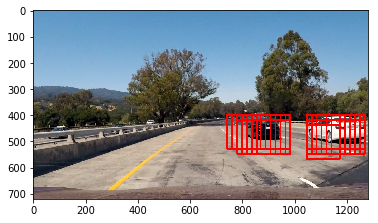

In [20]:
copy_img = draw_boxes(image, searched_windows, color=(0, 0, 255), thick=6)
plt.imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
def non_max_suppression_fast(boxes, overlapThresh):
    boxes = np.array(boxes).reshape((-1, 4))
    boxes = boxes.astype(float)
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    output_boxes = boxes[pick].astype("int")
    output_boxes = output_boxes[output_boxes[:,0].argsort()]
    output_boxes = output_boxes[output_boxes[:,2].argsort()]
    outputs_real = []
    for i in range(0, output_boxes.shape[0], 2):
        try:
            outputs_real.append([output_boxes[i, 0], output_boxes[i, 1], output_boxes[i + 1, 2], output_boxes[i, 3]])
        except:
            continue
    temp = np.array(outputs_real).reshape([-1, 2, 2]).tolist()
    return [((tuple(i[0]), tuple(i[1]))) for i in temp]

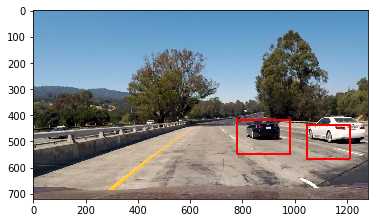

In [26]:
copy_img = draw_boxes(image, non_max_suppression_fast(searched_windows, 0.5), color=(0, 0, 255), thick=6)
plt.imshow(cv2.cvtColor(copy_img, cv2.COLOR_BGR2RGB))
plt.show()